In [1]:
import numpy as np
import pandas as pd
import os
import os.path
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import tensorflow as tf
import zipfile
import shutil
import seaborn as sns
from tqdm import tqdm
import shap

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2024-12-12 20:01:57.128745: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-12 20:01:57.128812: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/lhbdx/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#download locations
download_location= "./archive"
cleancsv_file= './all_clean.csv'


In [3]:
df = pd.read_csv(cleancsv_file, dtype='string', na_values=['-'])
df=df[df.isna().sum().sort_values().keys()]
df

,species,year,institute,code,Ciprofloxacin,Imipenem,Cefepime,Piperacillin-Tazobactam,Amoxicillin-Clavulanic acid,Ceftriaxone,...,Azithromycin,Ceftolozane-Tazobactam,Novobiocin,Ceftazidime-Avibactam,Minocycline,Cefalotin-Cefazolin,Cefotaxime,Meropenem-Vaborbactam,Ofloxacin,Pefloxacin
0,Klebsiella pneumoniae,2018,DRIAMS-B,ca568529-351a-43af-8cec-7175488f66ea,S,S,S,S,S,S,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,Proteus mirabilis,2018,DRIAMS-B,0fd4fd1a-8233-400d-bdee-f0c13819dc6b,S,S,S,S,S,S,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,Staphylococcus aureus,2018,DRIAMS-B,b1fa5e1c-d013-4716-b4b0-6552ad1c50de,S,<NA>,S,<NA>,S,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,Staphylococcus aureus,2018,DRIAMS-B,00aa2ddb-1819-475c-85e6-ed39d6efe6bc,S,<NA>,S,<NA>,S,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,Streptococcus pyogenes,2018,DRIAMS-B,1756cdc5-d0cd-43a9-be29-c2d28eb82013,<NA>,<NA>,<NA>,<NA>,S,S,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132281,Klebsiella oxytoca,2018,DRIAMS-C,28083007750_A10,S,S,S,S,S,S,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
132282,Staphylococcus aureus,2018,DRIAMS-C,28083009590_G2,S,<NA>,<NA>,<NA>,S,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
132283,Staphylococcus aureus,2018,DRIAMS-C,28083010580_G6,S,<NA>,<NA>,<NA>,S,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
132284,Enterococcus avium,2018,DRIAMS-C,28083011100_A8,<NA>,<NA>,<NA>,S,S,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [4]:
# Target selection for all organisms
antimicrobial = 'Amoxicillin-Clavulanic acid'

# Drop columns with all NaN values
pa_df = df.dropna(axis=1, how='all')

# Replace 'I' with 'R' in the antimicrobial column
pa_df.replace({antimicrobial: 'I'}, {antimicrobial: 'R'}, inplace=True)

# Filter rows where the antimicrobial column has 'S' (Susceptible) or 'R' (Resistant)
pa_df = pa_df[(pa_df[antimicrobial] == 'S') | (pa_df[antimicrobial] == 'R')]

# Select relevant columns for training
pa_df = pa_df[['code', 'species', antimicrobial, 'year', 'institute']]

# Display the processed DataFrame
print(pa_df.head())


/tmp/ipykernel_3940334/2165233672.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pa_df.replace({antimicrobial: 'I'}, {antimicrobial: 'R'}, inplace=True)


                                   code                 species  \
0  ca568529-351a-43af-8cec-7175488f66ea   Klebsiella pneumoniae   
1  0fd4fd1a-8233-400d-bdee-f0c13819dc6b       Proteus mirabilis   
2  b1fa5e1c-d013-4716-b4b0-6552ad1c50de   Staphylococcus aureus   
3  00aa2ddb-1819-475c-85e6-ed39d6efe6bc   Staphylococcus aureus   
4  1756cdc5-d0cd-43a9-be29-c2d28eb82013  Streptococcus pyogenes   

  Amoxicillin-Clavulanic acid  year institute  
0                           S  2018  DRIAMS-B  
1                           S  2018  DRIAMS-B  
2                           S  2018  DRIAMS-B  
3                           S  2018  DRIAMS-B  
4                           S  2018  DRIAMS-B  


In [5]:
def load_spectra(row):
    df = pd.read_csv(f'{download_location}/{row["institute"]}/binned_6000/{row["year"]}/{row["code"]}.txt', sep=" ")
    return df['binned_intensity'].to_numpy()
pa_df['bins'] = pa_df.apply(load_spectra, axis=1)

classes = pa_df[antimicrobial].value_counts().apply(lambda x: 500/x).to_numpy()
class_weight = {}
for idx in range(len(classes)):
    class_weight[idx] = classes[idx]

inputs = np.vstack(pa_df['bins'].to_numpy())
targets = pa_df[antimicrobial].apply(lambda x: x == 'R').to_numpy()

print("Input shape:", inputs.shape)
print("Target shape:", targets.shape)

Input shape: (38358, 6000)
Target shape: (38358,)


In [12]:
class_weight

{0: 0.12658227848101267, 1: 0.6459948320413437}

In [6]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

# Show shapes
print("X_train set shapes:", X_train.shape, )
print("X_test set shapes:", X_test.shape)
print("y_train set shapes:", y_train.shape)
print("y_test set shapes:", y_test.shape)


X_train set shapes: (30686, 6000)
X_test set shapes: (7672, 6000)
y_train set shapes: (30686,)
y_test set shapes: (7672,)


In [8]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model (or any model of your choice)
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate the model
print("Model Accuracy:", model.score(X_test, y_test))

Model Accuracy: 0.8557090719499478


In [9]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.515).astype(int)  # Convert probabilities to class labels (0 or 1)

report = classification_report(y_test, y_pred_classes, target_names=['Susceptible (S)', 'Resistant (R)'])
print(report)


                 precision    recall  f1-score   support

Susceptible (S)       0.84      0.96      0.90      5015
  Resistant (R)       0.89      0.67      0.76      2657

       accuracy                           0.86      7672
      macro avg       0.87      0.81      0.83      7672
   weighted avg       0.86      0.86      0.85      7672



In [14]:
# Define the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

2024-12-12 16:46:08.721032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/cv2/../../lib64:
2024-12-12 16:46:08.721288: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/cv2/../../lib64:
2024-12-12 16:46:08.721468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/cv2/../../lib64:
2024-12-12 16:46:08.721613: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [16]:
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [33]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
95/95 [==============================] - 2s 21ms/step - loss: 0.1401 - accuracy: 0.9590 - val_loss: 0.2414 - val_accuracy: 0.9101
Epoch 2/50
95/95 [==============================] - 2s 24ms/step - loss: 0.1513 - accuracy: 0.9543 - val_loss: 0.2181 - val_accuracy: 0.9220
Epoch 3/50
95/95 [==============================] - 1s 15ms/step - loss: 0.1358 - accuracy: 0.9543 - val_loss: 0.2464 - val_accuracy: 0.9074
Epoch 4/50
95/95 [==============================] - 2s 16ms/step - loss: 0.1435 - accuracy: 0.9587 - val_loss: 0.2539 - val_accuracy: 0.9339
Epoch 5/50
95/95 [==============================] - 2s 19ms/step - loss: 0.1348 - accuracy: 0.9543 - val_loss: 0.2667 - val_accuracy: 0.9272
Epoch 6/50
95/95 [==============================] - 1s 15ms/step - loss: 0.1582 - accuracy: 0.9510 - val_loss: 0.2414 - val_accuracy: 0.9259
Epoch 7/50
95/95 [==============================] - 2s 18ms/step - loss: 0.1355 - accuracy: 0.9616 - val_loss: 0.2157 - val_accuracy: 0.9220
Epoch 8/50
95

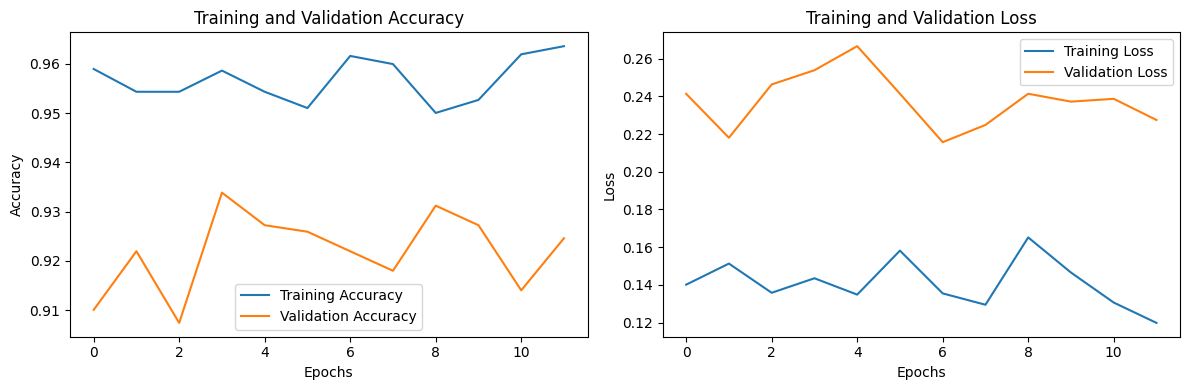

In [34]:
# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


<Figure size 600x600 with 0 Axes>

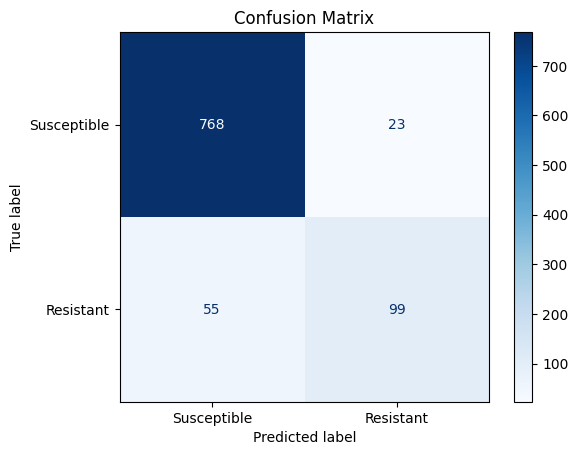

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Susceptible', 'Resistant'])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [36]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)

report = classification_report(y_test, y_pred_classes, target_names=['Susceptible (S)', 'Resistant (R)'])
print(report)


                 precision    recall  f1-score   support

Susceptible (S)       0.93      0.97      0.95       791
  Resistant (R)       0.81      0.64      0.72       154

       accuracy                           0.92       945
      macro avg       0.87      0.81      0.83       945
   weighted avg       0.91      0.92      0.91       945



In [32]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.515).astype(int)  # Convert probabilities to class labels (0 or 1)

report = classification_report(y_test, y_pred_classes, target_names=['Susceptible (S)', 'Resistant (R)'])
print(report)


                 precision    recall  f1-score   support

Susceptible (S)       0.94      0.97      0.95       791
  Resistant (R)       0.81      0.68      0.74       154

       accuracy                           0.92       945
      macro avg       0.88      0.82      0.85       945
   weighted avg       0.92      0.92      0.92       945



In [26]:
def predict_resistant_microbes(antimicrobial_name, model, threshold=0.5):
    antimicrobial_label = { antimicrobial_name : 'R'}  # mapping push
    
    #Alexander is smarts
    if antimicrobial_name not in antimicrobial_label:
        print("Antimicrobial not found in the mapping.")
        return None
    
    label = antimicrobial_label[antimicrobial_name]
    probabilities = model.predict(X_test)
    probable_resistant_microbes_indices = np.where(probabilities >= threshold)[0]
    probable_resistant_microbes_data = X_test[probable_resistant_microbes_indices]
    
    return probable_resistant_microbes_data
antimicrobial_name = antimicrobial

In [27]:
#optimize threshold for highest
def find_highest_threshold(antimicrobial_name, model):
    highest_threshold_data = None
    highest_threshold = 0.1
    
    for threshold in range(100, 999):  # Range from 0.1 to 0.99 with steps of 0.001
        threshold /= 1000  # Convert to float
        
        probable_resistant_microbes_data = predict_resistant_microbes(antimicrobial_name, model, threshold)
        
        if len(probable_resistant_microbes_data) > 0:
            highest_threshold_data = probable_resistant_microbes_data
            highest_threshold = threshold
    
    return highest_threshold_data, highest_threshold

lowest_threshold_data, lowest_threshold = find_highest_threshold(antimicrobial_name, model)
print("Lowest non-zero threshold:", lowest_threshold)

Lowest non-zero threshold: 0.933


Best Threshold: 0.515
Best F1-Score: 0.738


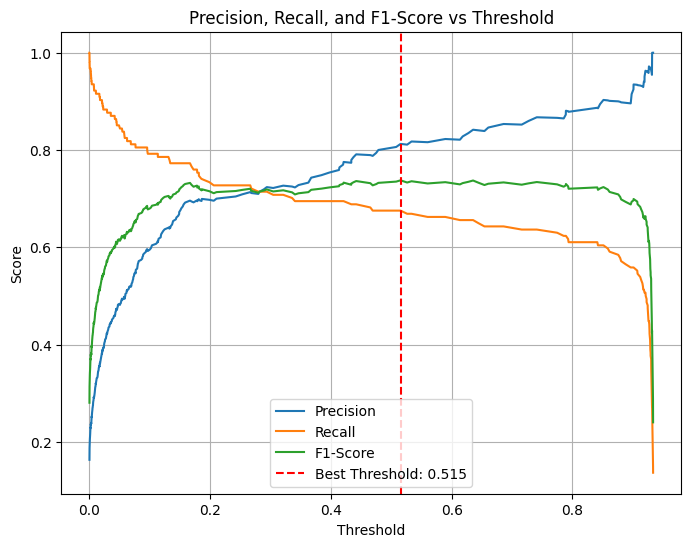

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

# Get predictions
y_pred_prob = model.predict(X_test)

# Generate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Compute F1-scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Adding a small epsilon to avoid division by zero

# Find the threshold that gives the highest F1-score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f"Best Threshold: {best_threshold:.3f}")
print(f"Best F1-Score: {best_f1_score:.3f}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1-Score')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score vs Threshold')
plt.legend()
plt.grid()
plt.show()


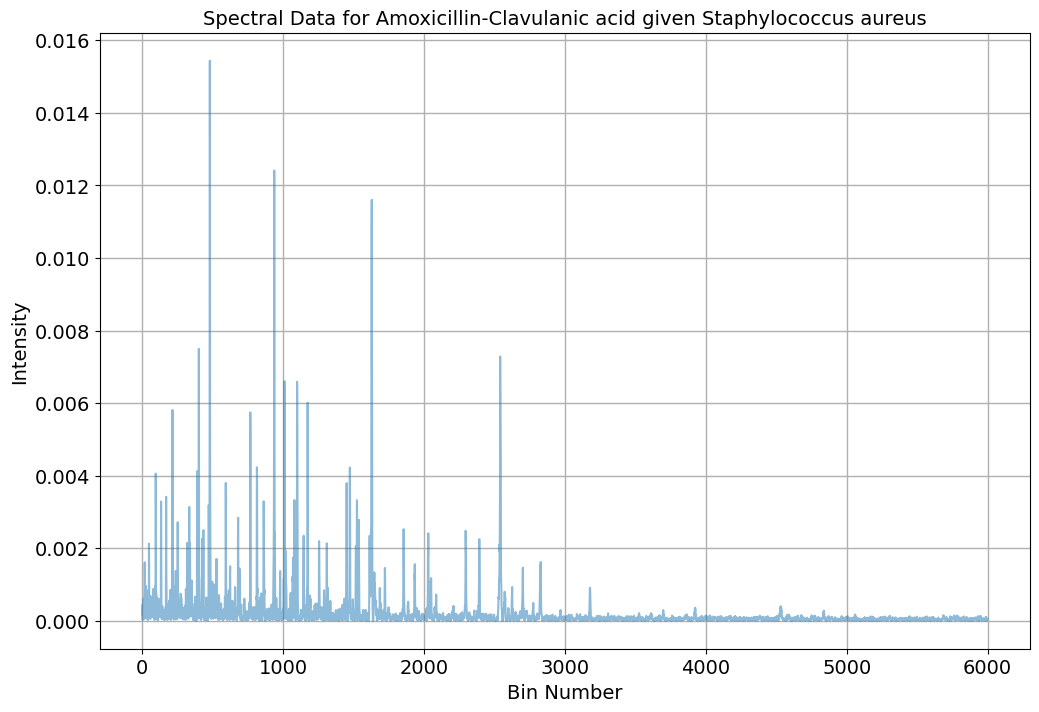

In [28]:
# Non-optimize route:
# probable_resistant_microbes_data= predict_resistant_microbes(antimicrobial_name, model, threshold=0.03)

def visualize_spectral_data(spectral_data):

    num_bins = spectral_data.shape[0]
    font_size = 14
    plt.figure(figsize=(12, 8), dpi=100)
    plt.plot(range(num_bins), spectral_data.T, alpha=0.5)
    plt.xlabel('Bin Number', fontsize=font_size)
    plt.ylabel('Intensity', fontsize=font_size)
    
    if organism == '': #general
         plt.title(f'Spectral Data for {antimicrobial_name}', fontsize=font_size)
    else: #organism specific
         plt.title(f'Spectral Data for {antimicrobial_name} given {organism}', fontsize=font_size)
    
    plt.grid(True, linewidth=1)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.show()

visualize_spectral_data(lowest_threshold_data[0])

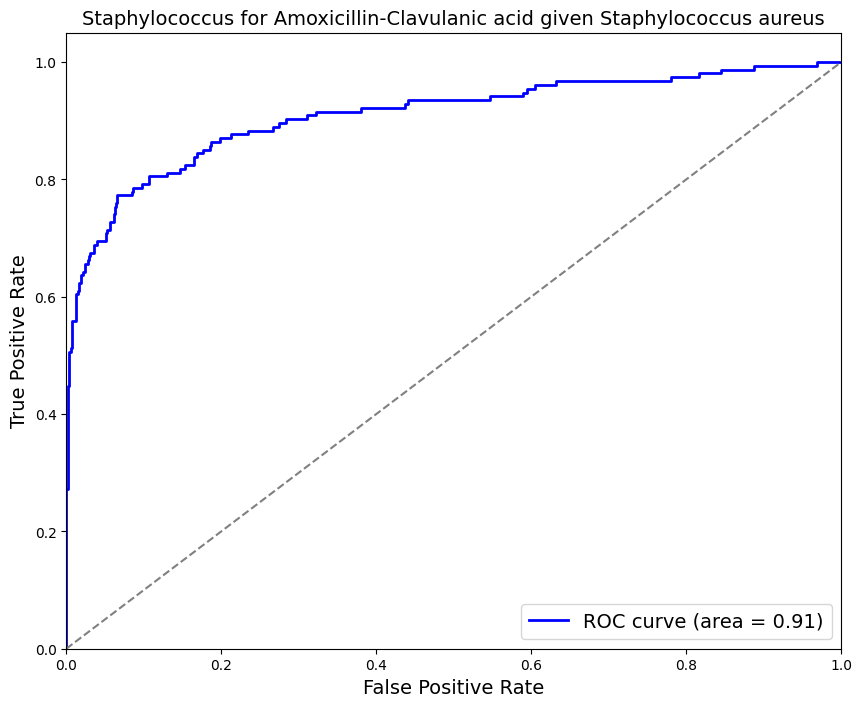

In [29]:
#ROC curve
probabilities = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)
font_size = 14
plt.figure(figsize=(10, 8), dpi=100)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=font_size)
plt.ylabel('True Positive Rate', fontsize=font_size)
if organism == '': #general
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {antimicrobial_name}', fontsize=font_size)
else: #organism specific
    plt.title(f'Staphylococcus for {antimicrobial_name} given {organism}', fontsize=font_size)
plt.legend(loc="lower right", fontsize=font_size)

plt.show()

